<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# _*Working with Different Backends*_ 

In this tutorial, we will first describe the various [backends](#backends) available in QISKit and how to find out more information about each of them, then we will explore how QISKit allows you to compile and run the same quantum circuit on different backends with different topology. 

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

***
### Contributors
Jay Gambetta, Joe Hellmers, Anna Phan

## The Backends<a id='backends'></a>

At the core of QISKit is the ability to access different backends to run your quantum programs. These backends are real devices, online simulators, and local simulations. As we continue to increase the flexibility of QISKit we expect there to be many different backends. These will include new hardware with different number of qubits, connectivity, different gate sets, and simulators with different properties. 

Current devices can be found on the devices page of the IBM Q Experience

Current simulators:
* QASM simulators - these simulate a quantum circuit and predict the outcomes of a quantum experiment.
    * Online QASM simulator – this runs online and can be used for up to 20 qubits with conditionals. 
    * Online HPC QASM simulator – this runs online and can be used for up to 32 qubits without conditionals. 
    * Local QASM simulator - this runs on your local machine, and should only be used for less than 10 qubits. 
* Local unitary simulator – predicts the unitary of a quantum circuit without measurement and conditional operations.
* Local statevector simulator - predicts the statevector of a quantum circuit without measurement and conditional operations.

The three important parts of our backends are: a provider, a backend, and a job object. The provider allows local and remote providers to be registered. QISkit comes with the default local provider which is a collection of simulators and it is simple to register the remote IBMQ provider. Each provider will give you access to different backends, which allow you to submit jobs to be run on the providers backends.

NOTE THIS IS WORK IN PROGRESS WHILE WE PUT THE SCHEMAS INTO THE BACKENDS

In [1]:
import sys, time, getpass
try:
    sys.path.append("../../") # go to parent dir
    import Qconfig
    qx_config = {
        "APItoken": Qconfig.APItoken,
        "url": Qconfig.config['url']}
    print('Qconfig loaded from %s.' % Qconfig.__file__)
except:
    APItoken = getpass.getpass('Please input your token and hit enter: ')
    qx_config = {
        "APItoken": APItoken,
        "url":"https://quantumexperience.ng.bluemix.net/api"}
    print('Qconfig.py not found in qiskit-tutorial directory; Qconfig loaded using user input.')

Qconfig loaded from ../../Qconfig.py.


In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, QISKitError
from qiskit import available_backends, execute, register, get_backend, compile

from qiskit.tools.visualization import plot_histogram
from pprint import pprint

### The Local and IBMQ providers

A provider must be registered and it must support three funtions: `available_backends()` and `get_backend()` and a method to register the provider.

```
available_backends() - list all the backends of the resistered backends
```
```
get_backend('name') - get a backend instance from a name 
```

Lets start with the  `available_backends()` command

In [3]:
available_backends()

['local_qasm_simulator',
 'local_statevector_simulator',
 'local_unitary_simulator']

This list is compact and picks the best of the diffent types. To list all the backends not just alias you can use:

In [4]:
available_backends(compact=False)

['local_clifford_simulator_cpp',
 'local_qasm_simulator_cpp',
 'local_qasm_simulator_py',
 'local_statevector_simulator_cpp',
 'local_statevector_simulator_py',
 'local_unitary_simulator_py']

To add the IBMQ provider you need to register it using

```
register(arg,...)
```

In [5]:
register(qx_config['APItoken'], qx_config['url'])
available_backends()

['ibmq_16_rueschlikon',
 'ibmq_5_tenerife',
 'ibmq_5_yorktown',
 'ibmq_qasm_simulator',
 'local_qasm_simulator',
 'local_statevector_simulator',
 'local_unitary_simulator']

The `available_backends` function can also use filters.

Filter: show remote backends only

In [6]:
available_backends({'local': False})

['ibmq_16_rueschlikon',
 'ibmq_5_tenerife',
 'ibmq_5_yorktown',
 'ibmq_qasm_simulator']

Filter: show only local backends

In [7]:
available_backends({'local': True})

['local_qasm_simulator',
 'local_statevector_simulator',
 'local_unitary_simulator']

Filer: show only simulators

In [8]:
available_backends({'simulator': True})

['ibmq_qasm_simulator',
 'local_qasm_simulator',
 'local_statevector_simulator',
 'local_unitary_simulator']

Fileter: show only real devices

In [9]:
available_backends({'simulator': False})

['ibmq_16_rueschlikon', 'ibmq_5_tenerife', 'ibmq_5_yorktown']

Filter: show both a remote backend and a simulator backend

In [10]:
available_backends({'local': False, 'simulator': True})

['ibmq_qasm_simulator']

The second function `get_backend()` allows you to make a backend instance

In [11]:
backends = []
for backend in available_backends():
    backends.append(get_backend(backend))
backends

### The Backends

The next part is the backend instances. These backends must support the following functions:

```
configuration - gets the configuration of the backend.
```
```
properties -  gets the properties of the backend (calibrations and parameters are going to be combined).
```
```
schema -  returns the schema for the qobj object supported by this backend (not implemented yet).
```
```
status - gets the status of the backend.
```
```
jobs  -  returns a list of the job id’s (not implemented yet).
```
```
retrieve_job - gets the data in the job (not implemented yet).
```
```
run  - runs a qobj on the backend.
```


Lets start with the `status`:

    `available` lets us know that the backend is taking jobs

    `pending_jobs` lets you know how many jobs are in the queue

In [12]:
for backend in backends:
    pprint(backend.status)

{'pending_jobs': 3, 'name': 'ibmqx5', 'operational': True}
{'pending_jobs': 0, 'name': 'ibmqx4', 'operational': True}
{'pending_jobs': 330, 'name': 'ibmqx2', 'operational': False}
{'pending_jobs': 0, 'name': 'ibmq_qasm_simulator', 'operational': True}
{'name': 'local_qasm_simulator_cpp', 'operational': True, 'pending_jobs': 0}
{'name': 'local_statevector_simulator_cpp',
 'operational': True,
 'pending_jobs': 0}
{'name': 'local_unitary_simulator_py', 'operational': True, 'pending_jobs': 0}


The next is `configuration`

In [13]:
for backend in backends:
    pprint(backend.configuration)

{'allow_q_object': False,
 'basis_gates': 'u1,u2,u3,cx,id',
 'chip_name': 'Albatross',
 'coupling_map': [[1, 0],
                  [1, 2],
                  [2, 3],
                  [3, 4],
                  [3, 14],
                  [5, 4],
                  [6, 5],
                  [6, 7],
                  [6, 11],
                  [7, 10],
                  [8, 7],
                  [9, 8],
                  [9, 10],
                  [11, 10],
                  [12, 5],
                  [12, 11],
                  [12, 13],
                  [13, 4],
                  [13, 14],
                  [15, 0],
                  [15, 2],
                  [15, 14]],
 'description': '16 transmon 2x8 ladder',
 'gate_set': 'SU2+CNOT',
 'local': False,
 'n_qubits': 16,
 'name': 'ibmqx5',
 'online_date': '2017-09-21T00:00:00.000Z',
 'simulator': False,
 'url': 'https://ibm.biz/qiskit-ibmqx5',
 'version': '1.1.0'}
{'allow_q_object': False,
 'basis_gates': 'u1,u2,u3,cx,id',
 'chip_name': '

In [14]:
for backend in backends:
    pprint(backend.parameters)

{'backend': 'ibmqx5',
 'fridge_parameters': {'Temperature': {'date': '2018-07-08T03:43:21Z',
                                       'unit': 'K',
                                       'value': 0.0141844},
                       'cooldownDate': '2017-09-15'},
 'last_update_date': '2018-07-08T10:31:12.000Z',
 'qubits': [{'T1': {'date': '2018-07-08T10:30:11Z',
                    'unit': 'µs',
                    'value': 41.2},
             'T2': {'date': '2018-07-08T10:31:12Z',
                    'unit': 'µs',
                    'value': 23.9},
             'buffer': {'date': '2018-07-08T10:05:31Z',
                        'unit': 'ns',
                        'value': 10},
             'frequency': {'date': '2018-07-08T10:05:31Z',
                           'units': 'GHz',
                           'value': 5.2559226},
             'gateTime': {'date': '2018-07-08T10:05:31Z',
                          'unit': 'ns',
                          'value': 80},
             'name': 'Q0'},


{'backend': 'ibmqx4',
 'fridge_parameters': {'Temperature': {'date': '-', 'unit': '-', 'value': []},
                       'cooldownDate': '2017-09-07'},
 'last_update_date': '2018-07-09T01:56:39.000Z',
 'qubits': [{'T1': {'date': '2018-07-09T01:56:39Z',
                    'unit': 'µs',
                    'value': 52.7},
             'T2': {'date': '2018-07-09T01:56:39Z',
                    'unit': 'µs',
                    'value': 48.3},
             'buffer': {'date': '2018-07-09T01:56:39Z',
                        'unit': 'ns',
                        'value': 10},
             'frequency': {'date': '2018-07-09T01:56:39Z',
                           'unit': 'GHz',
                           'value': 5.24991},
             'gateTime': {'date': '2018-07-09T01:56:39Z',
                          'unit': 'ns',
                          'value': 60},
             'name': 'Q0'},
            {'T1': {'date': '2018-07-09T01:56:39Z',
                    'unit': 'µs',
                    '

In [15]:
for backend in backends:
    pprint(backend.calibration)

{'backend': 'ibmqx5',
 'last_update_date': '2018-07-08T11:44:49.000Z',
 'multi_qubit_gates': [{'gateError': {'date': '2018-07-08T11:12:10Z',
                                      'value': 0.04744202981165879},
                        'name': 'CX1_0',
                        'qubits': [1, 0],
                        'type': 'CX'},
                       {'gateError': {'date': '2018-07-08T11:44:49Z',
                                      'value': 0.0457248442740415},
                        'name': 'CX1_2',
                        'qubits': [1, 2],
                        'type': 'CX'},
                       {'gateError': {'date': '2018-07-08T11:12:10Z',
                                      'value': 0.03860667353420849},
                        'name': 'CX2_3',
                        'qubits': [2, 3],
                        'type': 'CX'},
                       {'gateError': {'date': '2018-07-08T11:44:49Z',
                                      'value': 0.05156382596359482},
        

{'backend': 'ibmqx4',
 'last_update_date': '2018-07-09T01:56:39.000Z',
 'multi_qubit_gates': [{'gateError': {'date': '2018-07-09T01:56:39Z',
                                      'value': 0.03282856970898512},
                        'name': 'CX1_0',
                        'qubits': [1, 0],
                        'type': 'CX'},
                       {'gateError': {'date': '2018-07-09T01:56:39Z',
                                      'value': 0.023654165328270943},
                        'name': 'CX2_0',
                        'qubits': [2, 0],
                        'type': 'CX'},
                       {'gateError': {'date': '2018-07-09T01:56:39Z',
                                      'value': 0.06001720269731553},
                        'name': 'CX2_1',
                        'qubits': [2, 1],
                        'type': 'CX'},
                       {'gateError': {'date': '2018-07-09T01:56:39Z',
                                      'value': 0.053153184044521934},
     

### The Jobs object

To get a job first we must get a qobj which is a quantum object. This is a list of circuits compiled to a backend. To get this we have made a `compile` funtion that converts an array of circuits into a `qobj`. The reason this is an array is for current hardware lists of circuits are loaded onto the equipment at once and it is much more efficent to run this in a batch mode. The methods of the jobs object are:

```
status - returns the status.
```
```
done - returns a bool true if done.
```
```
id  - gets the job_id (not supported in the local provider yet).
```
```
cancel - cancels the job (not supported on remote-public or local. Only supported on IBM Q premium devices).
```
```
result - gets the results from the circuit run.
```

In [16]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
circuit = QuantumCircuit(qr, cr)
circuit.x(qr[0])
circuit.x(qr[1])
circuit.ccx(qr[0], qr[1], qr[2])
circuit.cx(qr[0], qr[1])
circuit.measure(qr, cr)

In [17]:
my_backend = get_backend('local_qasm_simulator')

In [18]:
qobj = compile(circuit, backend=my_backend, shots=1024)
job = my_backend.run(qobj)

In [19]:
job.status

{'status': <JobStatus.RUNNING: 'job is actively running'>, 'status_msg': None}

In [20]:
job.done

True

In [21]:
result = job.result()
counts = result.get_counts()
print(counts)

{'101': 1024}


In [22]:
my_backend = get_backend('ibmqx4')

In [23]:
qobj = compile(circuit, backend=my_backend, shots=1024)
job = my_backend.run(qobj)

In [24]:
lapse = 0
interval = 10
while not job.done:
    print('Status @ {} seconds'.format(interval * lapse))
    print(job.status)
    time.sleep(interval)
    lapse += 1
print(job.status)

Status @ 0 seconds
{'job_id': None, 'status': <JobStatus.INITIALIZING: 'job is being initialized'>, 'status_msg': 'Job is initializing. Please, wait a moment.'}
Status @ 10 seconds
{'job_id': '5b42c4142dddcd00395845dd', 'status': <JobStatus.RUNNING: 'job is actively running'>, 'status_msg': 'job is actively running'}
Status @ 20 seconds
{'job_id': '5b42c4142dddcd00395845dd', 'status': <JobStatus.RUNNING: 'job is actively running'>, 'status_msg': 'job is actively running'}
{'job_id': '5b42c4142dddcd00395845dd', 'status': <JobStatus.DONE: 'job has successfully run'>, 'status_msg': 'job has successfully run'}


In [25]:
job.id

'5b42c4142dddcd00395845dd'

In [26]:
result = job.result()
counts = result.get_counts()
print(counts)

{'000': 25, '001': 115, '010': 25, '011': 48, '100': 57, '101': 668, '110': 31, '111': 55}


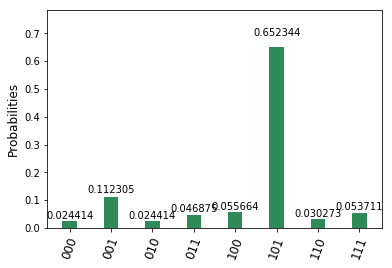

In [27]:
plot_histogram(counts)